# Import the Necessarry Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.image import imread
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from PIL import Image

Using TensorFlow backend.


# Sign Launguage Training Data

In [155]:
train_data = pd.read_csv("sign_mnist_train.csv")

# Current State of the Dataset
-labels are 0-24 to represent each letter in the alphabet excluding 'J' and 'Z' which are '9' and '25' respectively                
-images are represented by 784 pixels ranging from 0-255


In [3]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train_data.shape

(27455, 785)

In [5]:
labels = train_data.label.unique()
labels.sort()
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

## adjust labels so we dont skip class 9 which was originally 'J'. This would give us issues later when attempting to validate later

In [6]:
for i in range(0, 27455):
    if train_data['label'][i] >= 10:
        train_data['label'][i] -= 1
labels = train_data.label.unique()
labels.sort()
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

### Seperate the labels from the data for validation later

In [7]:
labels = train_data['label'].values

In [8]:
train_data.drop("label" , axis=1 , inplace=True) #remove 'labels' columns

## Turn labels into a list of 24 '0's with a '1' in the place of the letter respective to its position in the alphabet
#### example: An 'A' would be [1,0,0, ..., 0, 0, 0], B would be [0,1,0, ..., 0,0,0], etc...

In [9]:
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)

In [10]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

## We can now take all of the remaining values and begin constructing the images

In [11]:
image_data = train_data.values
image_data

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]])

In [12]:
image_data[0].shape

(784,)

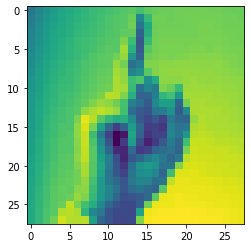

In [13]:
plt.imshow(image_data[0].reshape(28,28))

### We can now begin preproccessing the images to get them ready for the training

In [14]:
images = np.array([image_data[i].reshape(28,28) for i in range(image_data.shape[0])])

In [15]:
flatten_images = np.array([i.flatten() for i in images])

### We now take the test data and split it into 70% training data and 30% test data. Then it will then train itself and then test itself based on what the machine knows already to become "smarter"

In [16]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 101)

### Normalizing the data

In [17]:
x_train = x_train / 255
x_test = x_test / 255

#### Parameters that will go into the testing fuction. These are put into variables to allow for quick changes to test the effects these might have on accuracy. This is esspecially true for 'epochs' which is how many generations the machine will go through in testing. the more generations usually the higher accuracy but comes with some issues as well.

In [18]:
batch_size = 128
num_classes = 24
epochs = 50

In [19]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

In [20]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

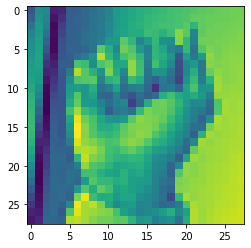

In [21]:
plt.imshow(x_train[0].reshape(28,28))

### Below is the actual function that will essentially be making our machine into a model that we can further test against after the fact. Each time an image is tested the image is broken down and "blurred" more so pixels become more distinguishable. This allows the model to make generalizations about each image to make the determination about what it is seeing. 

In [22]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))


model.add(Dense(num_classes, activation = 'softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
# model = Sequential([
    #Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    #MaxPooling2D(),
    #Conv2D(32, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Conv2D(64, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Flatten(),
    #Dense(512, activation='relu'),
    #Dense(1)


### compile the function and implement our loss that will better handle data with several classes along with our optimizer and  also make sure we keep track of our accuracy.

In [24]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [25]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 19218 samples, validate on 8237 samples
Epoch 1/50





19218/19218 [==============================] - 19s 964us/step - loss: 2.6160 - acc: 0.1945 - val_loss: 1.6544 - val_acc: 0.5056
Epoch 2/50
19218/19218 [==============================] - 18s 922us/step - loss: 1.3301 - acc: 0.5608 - val_loss: 0.9135 - val_acc: 0.7147
Epoch 3/50
19218/19218 [==============================] - 18s 954us/step - loss: 0.8257 - acc: 0.7197 - val_loss: 0.5838 - val_acc: 0.8122
Epoch 4/50
19218/19218 [==============================] - 19s 989us/step - loss: 0.5704 - acc: 0.8088 - val_loss: 0.3830 - val_acc: 0.8892
Epoch 5/50
19218/19218 [==============================] - 18s 954us/step - loss: 0.3956 - acc: 0.8673 - val_loss: 0.2740 - val_acc: 0.9188
Epoch 6/50
19218/19218 [==============================] - 18s 920us/step - loss: 0.2839 - acc: 0.9069 - val_loss: 0.1951 - val_acc: 0.9414
Epoch 7/50
1921

## Print out a chart of the accuracy
### as you can see the training starts at about 0 and testing starts at around .5 and both quickly approach 90%

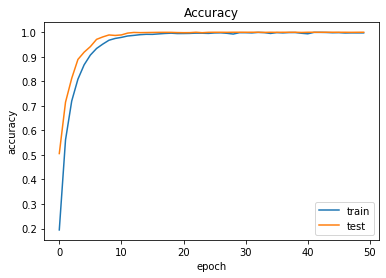

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

plt.show()

### summary data of the testing and how many paramters we are testing against through each convolution

In [27]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

# Load Test Data

In [28]:
test_data = pd.read_csv("sign_mnist_test.csv")

#### Here is the same issue with the missing '9' in our test data that we will need to fix

In [29]:
test_data.head()
test_data.label.unique()


array([ 6,  5, 10,  0,  3, 21, 14,  7,  8, 12,  4, 22,  2, 15,  1, 13, 19,
       18, 23, 17, 20, 16, 11, 24])

In [30]:
test_data.shape

(7172, 785)

### Move any label that is 10 or higher down

In [31]:
for i in range(0, 7171):
    if test_data['label'][i] >= 10:
        test_data['label'][i] -= 1
        

### problem solved

In [156]:
incorrect

array([  14,   27,   43,   48,   58,   61,   68,   88,   89,   93,  107,
        115,  123,  133,  139,  141,  151,  154,  161,  177,  191,  193,
        195,  201,  202,  207,  215,  217,  219,  224,  236,  248,  249,
        267,  273,  281,  288,  292,  296,  298,  299,  313,  318,  320,
        326,  328,  335,  343,  346,  365,  374,  376,  379,  389,  392,
        398,  411,  417,  422,  423,  425,  439,  442,  444,  452,  454,
        455,  456,  457,  460,  462,  489,  510,  516,  528,  529,  532,
        544,  552,  553,  564,  568,  575,  583,  585,  591,  613,  627,
        634,  637,  638,  643,  645,  662,  668,  674,  675,  676,  686,
        688,  691,  696,  706,  708,  717,  727,  735,  739,  742,  755,
        757,  775,  788,  790,  817,  824,  835,  837,  846,  851,  861,
        877,  887,  922,  931,  937,  944,  948,  949,  960,  986,  989,
        998,  999, 1005, 1013, 1018, 1036, 1038, 1040, 1042, 1050, 1052,
       1053, 1071, 1082, 1091, 1092, 1110, 1111, 11

In [32]:
test_data.label.unique()


array([ 6,  5,  9,  0,  3, 20, 13,  7,  8, 11,  4, 21,  2, 14,  1, 12, 18,
       17, 22, 16, 19, 15, 10, 23])

## rinse repeat our data cleaning from before to prepare for testing

In [33]:
y_true = test_data.iloc[:, 0]

In [34]:
test_labels = test_data['label']

In [35]:
test_labels = label_binrizer.fit_transform(test_labels)

In [36]:
test_data.drop("label" , axis=1 , inplace=True)

In [37]:
test_image_data = test_data.values
test_image_data

array([[149, 149, 150, ..., 112, 120, 107],
       [126, 128, 131, ..., 184, 182, 180],
       [ 85,  88,  92, ..., 225, 224, 222],
       ...,
       [190, 191, 190, ..., 211, 209, 208],
       [201, 205, 208, ...,  67,  70,  63],
       [173, 174, 173, ..., 195, 193, 192]])

### our images as expected

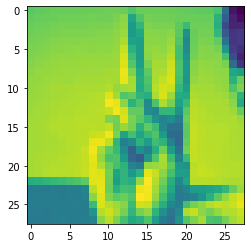

In [38]:
plt.imshow(test_image_data[1229].reshape(28,28))

In [39]:
#flatten_images = np.array([i.flatten() for i in images])

In [40]:
#flatten_images

### Reshape images into 28 x 28 and make 'target_names' so we can use the classes in a more visual representation of our validation later

In [41]:
test_images = np.array([test_image_data[i].reshape(28,28) for i in range(test_image_data.shape[0])])

In [42]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [43]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
target_names

['Class 0',
 'Class 1',
 'Class 2',
 'Class 3',
 'Class 4',
 'Class 5',
 'Class 6',
 'Class 7',
 'Class 8',
 'Class 9',
 'Class 10',
 'Class 11',
 'Class 12',
 'Class 13',
 'Class 14',
 'Class 15',
 'Class 16',
 'Class 17',
 'Class 18',
 'Class 19',
 'Class 20',
 'Class 21',
 'Class 22',
 'Class 23']

### send images to the model to predict against our new test data

In [44]:
flatten_images = np.array([i.flatten() for i in test_images])

In [45]:
y_pred = model.predict(test_images)


### our overall accuracy 

In [108]:
accuracy_score(test_labels, y_pred.round())

0.867122141662019

### make a seperate dataframe that is made up of our predictions made on the test images

In [47]:
test_pred = pd.DataFrame(model.predict(test_images))

In [48]:
predicted_classes = model.predict_classes(test_images)

### Now we can get our hands on the correct and incorrect answers and seperate them

In [91]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

/Users/mark/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [50]:
target_names = ["Class {}".format(i) for i in range(num_classes)]

In [51]:
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.82      1.00      0.90       331
     Class 1       1.00      0.96      0.98       432
     Class 2       0.94      0.93      0.93       310
     Class 3       1.00      0.81      0.90       245
     Class 4       0.92      1.00      0.96       498
     Class 5       1.00      1.00      1.00       247
     Class 6       0.75      0.76      0.76       348
     Class 7       0.89      0.86      0.88       436
     Class 8       0.87      0.90      0.88       288
     Class 9       1.00      0.80      0.89       331
    Class 10       0.80      0.99      0.88       209
    Class 11       0.86      0.95      0.90       394
    Class 12       1.00      0.75      0.86       291
    Class 13       0.91      0.83      0.87       246
    Class 14       1.00      0.63      0.77       347
    Class 15       0.67      0.99      0.80       164
    Class 16       0.43      0.63      0.51       144
    Class 17       0.80    

In [101]:
len(list(correct))

6219

In [99]:
len(list(incorrect))

953

### A more visual representation of what we know already

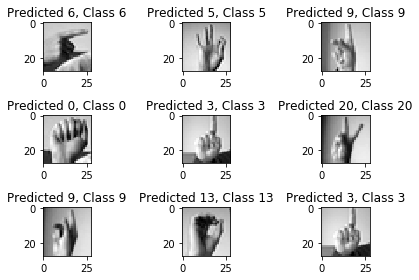

In [54]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_true[correct]))
    plt.tight_layout()

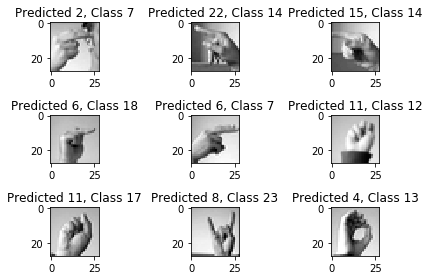

In [55]:
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_true[incorrect]))
    plt.tight_layout()

In [56]:
#flatten_images = np.array([i.flatten() for i in images])
#test_images = np.array([test_image_data[i].reshape(28,28) for i in range(test_image_data.shape[0])])

In [57]:
#img = imread('q.jpg')
#fname = 'q.jpg'
#image = Image.open(fname).convert("L")
#arr = np.asarray(image)
#plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
#plt.show()

In [58]:
#arr = arr / 255

In [59]:
#arr

In [60]:
#predicted_img = model.predict_classes(flatten_img)

### User input from images off of the internet!

In [153]:
img = image.load_img('v.jpg', color_mode = "grayscale", target_size=(28,28))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images)



In [154]:

print(classes)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
